**MNIST를 이용한 LeNet-5 구현**

LeNet-5는 1998년 Yann LeCun이 publish한 Gradient-Based Learning Applied to Document Recognition의 논문을 바탕으로한 초기의 Convolutional Neural Network 구조이다.

LeNet-5는 7개의 layer로 이루어진 CNN이고, 32x32 pixel 크기의 흑백 이미지를 input으로 사용하였다.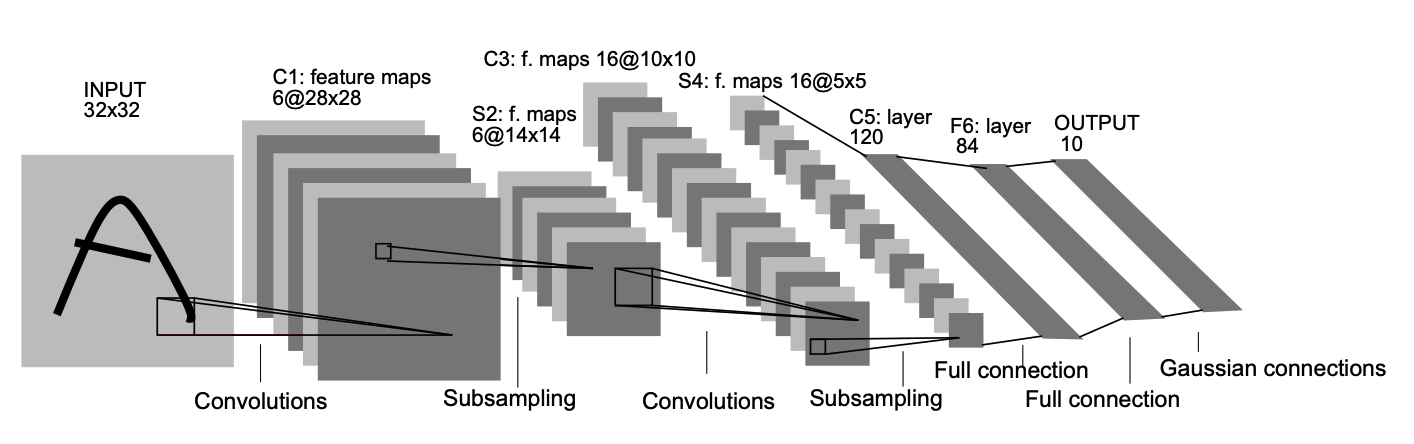
 


첫번째 Layer는 C1:Convolutional Layer로 6개의 output channel로 구성되어있고, kernel size=5x5, stride=1을 사용하였다. 첫번째 Layer를 통과하면 1x32x32  ->  6x28x28  로 크기가 바뀌게 된다.

두번째 Layer는 S2:Subsampling Layer로 max나 average pooling을 주로 사용한다. kernel size는 2x2, stride=2를 사용하였다. 두번째 Layer를 통과하면  6x28x28 -> 6x14x14의 크기가 된다.

세번째 Layer는 C3:Convolutional Layer로 16개의 output cahnnel로 구성되고, kernel size와 stride는 C1과 동일하게 사용하였다. 세번째 Layer를 통과하면 6x14x14 -> 16x10x10의 크기가 된다.

네번째 Layer는 S4:Subsampling Layer로, S2와 같은 kernel size와 stride를 사용하였다. 네번째 Layer를 통과하면 16x10x10 -> 16x5x5 가 된다.

다섯번째 Layer는 C5:Convolutional Layer로 120개의 output channel로 구성된다. kernel size는 C1, C2와 동일하며, 이 Layer를 통과하면 16x5x5 -> 120x1x1이 된다.

여섯번째 Layer는 F6:Fully Connected Layer로 84개의 노드를 output으로 가지며, 이 논문에서는 tahn를 activation function으로 사용하였다.

일곱번째 Layer는 Output Layer로 10개의 output node를 갖는다.

**** 
Convolutional layer의 output size는 

(W - F + 2P) / S + 1 

의 식을 사용하여 계산할 수 있다.. W는 input 이미지의 width/height 크기이며, F는 kernel(filter) size, P는 padding, 그리고 S는 stride를 의미한다.







**Pytorch를 이용해서 LeNet-5 구현해보기**




LeNet-5의 구현을 위해 MNIST dataset을 활용한다.


In [1]:
# 먼저 필요한 Library를 import한다.

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets 
import torchvision.transforms as transforms
from torchvision import utils

import matplotlib.pyplot as plt
%matplotlib inline

# 필요한 parameter를 미리 세팅한다.
random_seed=4
learning_rate=0.001
batch_size=32
epochs=10

image_size=32
n_classes=10  # 숫자 10개 0~9

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

MNIST dataset은 torchvision을 통해 다운로드 받을 수 있다.

In [2]:
# transform을 이용해서 우리가 원하는 형태의 data를 얻을 있게 변형시켜준다.
# transform.Compose()
# transfomr.Resize()는 mnist 이미지의 size를 변경해준다. LeNet-5 input은 32x32이다.
# transform.ToTensor()는 0~255 범위인 H x W x C 형태의 numpy array를 0.0~1.0 범위인 C x H x W 형태의 Tensor로 변환해준다.
# transfomr.Compose()는 transform.xxx인 함수들을 한번에 묶어서 처리시켜준다.
transforms=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

# data 다운로드하기 
dataPath='./MNIST_DATASET'   # 다운받을 곳의 path 정의
train_data=datasets.MNIST(dataPath, train=True, transform=transforms, download=True)  # traindataset
valid_data=datasets.MNIST(dataPath, train=False, transform=transforms) # validation dataset

# dataloader는 dataset을 batch size 만큼씩 나누어준다.
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
x_train, y_train=train_data.data, train_data.targets  # train_data의 이미지 데이터와 그 데이터의 groundtruth
x_valid, y_valid=valid_data.data, valid_data.targets  # valid data의 데이터와 target


torch.Size([60000, 28, 28])


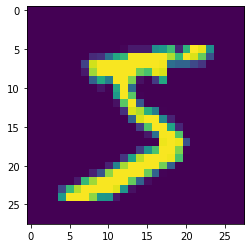

In [4]:
print(x_train.shape)
plt.imshow(x_train[0])   # sample mnist 이미지

LeNet-5 구현하기

In [5]:
class LeNet(nn.Module):  # nn.module에서 pytorch를 이용한 Neural Network의 여러 모델을 사용할 수 있음
  def __init__(self, n_classes):  # __init__()으로 LeNet class의 input variables를 세팅함.
    super().__init__()    
   
    self.conv1=nn.Conv2d(in_channels=1, out_channels= 6, kernel_size=5, stride=1)   # 위에서 봤듯이 MNIST input image는 32x32임.
                                                                                    # MNIST는 흑백 이미지이므로 1임. 따라서  input_channel은 1x32x32이 됨.
                                                                                    # 6은 output channel 수를 의미하고, 임의로 내가 정해줌.
                                                                                    # kernel_size(filter) = 5x5로 내가 임의로 정함.
                                                                                    # stride는 kernel이 이동하는 칸 수를 의미하고 여기서 1로 내가 임이로 정함.
                                                                                    # 이 convolution layer를 지나면 1x32x32 ->  6x28x28가 됨.
                                                                                    # 6은 output channel에 의한 크기이고,
                                                                                    # 28x28은 5x5필터와 stride=1를 이용해서 (28-kernelsize)/stride +1에 의해 계산됨.
                                                                                    #((32-5)/1 +1) x ((32-5)/1+1)  = 28 x 28 에 의해서 생성됨


    self.max_pool1=nn.MaxPool2d(2,2)           # max pooling(2)는 2개의 픽셀마다 한 개의 큰 값만 뽑아서 사용함.
                                               # kernel_size=2 이고, stride는 2임.
                                               # (28-2)/2+1 x (28-2)/2+1 로 14x14가 됨
                                               # maxpooling을 하면  6x28x28 -> 6x14x14 가 됨

    self.conv2=nn.Conv2d(6, 16, 5, 1)          # 앞의 크기는 6x14x14이므로, conv2의 input에는 6을 넣어줌.
                                               # 16은 output channel 수 임.
                                               # kernel size는 5x5이고 stride=1임.
                                               # (14-5)/1 +1 = 10
                                               # 이 convolution layer를 지나면 6x14x14 -> 16x10x10이 됨                                              

    self.max_pool2=nn.MaxPool2d(2,2)            # MaxPool2d(2)이므로 역시 반으로 줄어듬
                                               # (10-2)/2+1 = 5 
                                               # 16x10x10 -> 16x5x5   

    self.conv3=nn.Conv2d(16, 120, 5, 1)        # 앞의 크기는 16x5x5이므로, conv2의 input에는 16을 넣어줌.
                                               # 120은 output channel 수 임.
                                               # kernel size는 5x5이고 stride=1임.
                                               # (5-5)/1 +1 = 1
                                               # 이 convolution layer를 지나면 16x5x5 -> 120x1x1이 됨  

                                                                                  
                                                   

    # y= Wx+b 연산
    self.fc1=nn.Linear(in_features=120, out_features= 84)  # conv에서 넘어온 input 120개 node -> 84개 output node
    self.fc2=nn.Linear(84,n_classes)     # 84개 output node -> 10개의 output node (n_classes)
                                         # output이 10개인 이유는 MNIST가 숫자이므로 0~9까지 총 10개이기 때문이다.
    
  def forward(self, x):
    
    x=F.tanh(self.conv1(x))   # 1x32x32 -> 6x28x28   # LeNet-5 에서는 tanh를 activation function으로 사용했다.    
    x=self.max_pool1(x)       # 6x28x28 -> 6x14x14
    x=F.tanh(self.conv2(x))   # 6x14x14 -> 16x10x10
    x=self.max_pool2(x)       # 16x10x10 -> 16x5x5 
    x=F.tanh(self.conv3(x))   # 16x5x5 -> 120x1x1
    x=x.view(-1, 120)         
    x=F.tanh(self.fc1(x))     # 120 -> 84
    x=self.fc2(x)             # 84-> 10

    return F.softmax(x, dim=1)


In [6]:
torch.manual_seed(random_seed)
model=LeNet(n_classes).to(DEVICE)

In [7]:
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
from torchsummary import summary
summary(model, input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train

In [9]:
optimizer=optim.Adam(model.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()

In [10]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss=0
  count=0
  correct=0

  for batch in train_loader:
    X=batch[0]      # 이미지 data
    y_true=batch[1]   # ground truth

    X=X.to(device)
    y_true=y_true.to(device)
   
    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    running_loss += loss.item()*X.size(0)
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item() 
    batch_count=len(X)
    

    # Backward
    optimizer.zero_grad()  #  back propagation 이전에 gradient를 0을 세팅함.
    loss.backward()        # back propagation
    optimizer.step()       # update parameter

    count+=batch_count
    correct+=batch_correct

  epoch_loss=running_loss / len(train_loader.dataset)
  epoch_accuracy=correct/count
  return model, optimizer, epoch_loss, epoch_accuracy

In [11]:
def evaluation(valid_loader, model, criterion, device):
  model.eval()
  running_loss=0
  count=0
  correct=0

  for batch in valid_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)
    running_loss+=loss.item()*X.size(0)

    count+=batch_count
    correct+=batch_correct


  epoch_loss=running_loss/len(valid_loader.dataset)
  epoch_accuracy=correct/count  

  return model, epoch_loss, epoch_accuracy



In [12]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
  
  train_losses=[]
  valid_losses=[]

  train_accuracies=[]
  valid_accuracies=[]

  for epoch in range(epochs):

    # training
    model, optimizer, train_loss, train_accuracy=train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # validation
    with torch.no_grad():    # autograd를 꺼준다. autograd를 끄면 더 이상 자동으로 gradient를 계산 및 저장하지 않는다.(메모리 save)
      model, valid_loss, valid_accuracy=evaluation(valid_loader, model, criterion,device)
      valid_losses.append(valid_loss)
      valid_accuracies.append(valid_accuracy)

    if epoch%2==0:
      print('epoch: ', epoch, 'train_loss: ', train_loss, 'valid_loss: ', valid_loss)
      print('          train accuracy: ', train_accuracy, 'valid accuracy: ', valid_accuracy)

  return (train_losses, valid_losses), (train_accuracies, valid_accuracies)



In [13]:
(tr_loss, val_loss), (tr_acc, val_acc)=training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch:  0 train_loss:  1.539416940498352 valid_loss:  1.4870478466033936
          train accuracy:  0.9323166666666667 valid accuracy:  0.9763
epoch:  2 train_loss:  1.4806231486002603 valid_loss:  1.4808835357666015
          train accuracy:  0.9817833333333333 valid accuracy:  0.9806
epoch:  4 train_loss:  1.4750391259511313 valid_loss:  1.4771576303482055
          train accuracy:  0.9871166666666666 valid accuracy:  0.9845
epoch:  6 train_loss:  1.4734322251637777 valid_loss:  1.4765405124664306
          train accuracy:  0.9882 valid accuracy:  0.985
epoch:  8 train_loss:  1.4710727668762207 valid_loss:  1.4758518756866454
          train accuracy:  0.99065 valid accuracy:  0.9853


10번의 epoch 임에도 정확도가 97~98%로 굉장히 높게 나왔다.

참고

https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320